# Colour - HDRI - Examples: Advanced Processing with the Node-Graph

In this example, some Canon EOS 5D Mark II *CR2* images will be processed using the node-graph.

The following dependencies are required:

- [rawpy](https://pypi.org/project/rawpy)
- [lensfunpy](https://pypi.org/project/lensufnpy)
- [colour-datasets](https://pypi.org/project/colour-datasets)
- [Adobe DNG Converter](https://helpx.adobe.com/camera-raw/using/adobe-dng-converter.html) (or [dnglab](https://github.com/dnglab/dnglab) on Linux)

In [1]:
import logging
import multiprocessing
import numpy as np
import os

import rawpy
import pygraphviz

import colour
import colour_datasets

from colour_hdri import (
    ROOT_RESOURCES_EXAMPLES,
    GraphBatchMergeHDRI,
    GraphHDRI,
    GraphMergeHDRI,
    GraphPostMergeHDRI,
    GraphRawProcessingDNG,
    GraphRawProcessingCameraSensitivities,
    filter_files,
)
from colour_hdri.plotting import plot_HDRI_strip

# Rawpy crashes when ran from multiprocessing in a Docker container.
multiprocessing.set_start_method("spawn")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(process)d - %(levelname)s - %(message)s",
)

ROOT_RESOURCES = os.path.join(
    ROOT_RESOURCES_EXAMPLES, "frobisher_001"
)

colour.plotting.colour_style()

def _repr_svg_(self):
    return self.draw(format='svg').decode(self.encoding)

setattr(pygraphviz.AGraph, '_repr_svg_', _repr_svg_)

colour.utilities.set_default_float_dtype(np.float32)

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0           *
*   (clang-1500.3.9.4)]                                                       *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : v0.4.3-268-g496d94d84                                        *
*       colour-datasets : v0.1.1-224-ge4027ea                                 *
*       colour-hdri : v0.2.2-49-g4352a4f                                      *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.34.2                                                      *
*       matplotlib : 3.9.1              

## Raw Files Filtering

In [2]:
RAW_FILES = filter_files(ROOT_RESOURCES, ("CR2",))

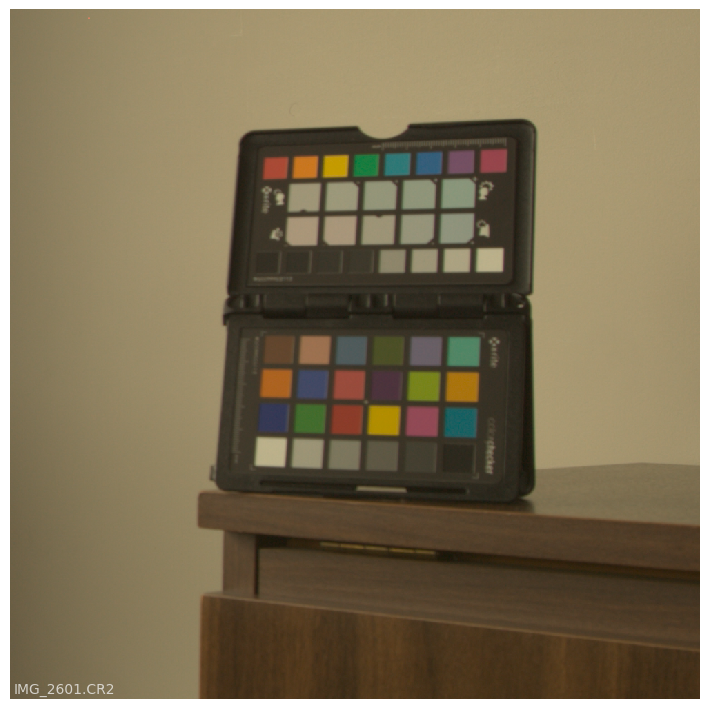

In [3]:
def read_raw_file_preview(path):
    raw = rawpy.imread(path).postprocess(
        gamma=(1, 1), no_auto_bright=True, output_bps=16
    )

    return colour.utilities.as_float_array(raw) / 65535


colour.plotting.plot_image(
    colour.cctf_encoding(
        read_raw_file_preview(RAW_FILES[-2])[1400:2400, 3200:4200, ...]
    ),
    text_kwargs={"text": os.path.basename(RAW_FILES[-2])},
);

## Processing a Single Image (DNG)

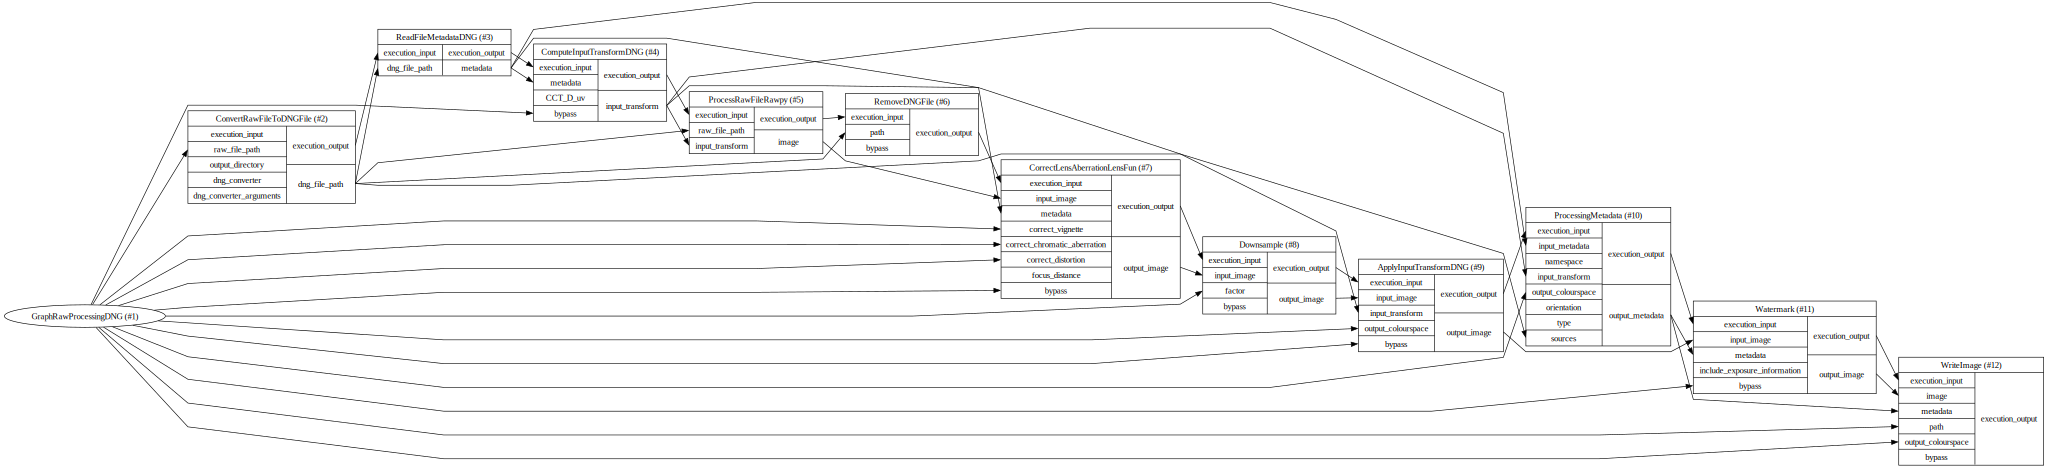

In [4]:
graph = GraphRawProcessingDNG()
to_graphviz = graph.to_graphviz()
to_graphviz.layout(prog="dot")
to_graphviz

2024-07-28 20:57:20,525 - 25734 - INFO - GraphRawProcessingDNG: Processing "NodeConvertRawFileToDNGFile#2(None)" node...
2024-07-28 20:57:20,525 - 25734 - INFO - Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
2024-07-28 20:57:24,421 - 25734 - INFO - GraphRawProcessingDNG: Processing "NodeReadFileMetadataDNG#3(None)" node...
2024-07-28 20:57:24,422 - 25734 - INFO - Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.dng" image EXIF data.
2024-07-28 20:57:24,588 - 25734 - INFO - GraphRawProcessingDNG: Processing "NodeComputeInputTransformDNG#4(None)" node...
2024

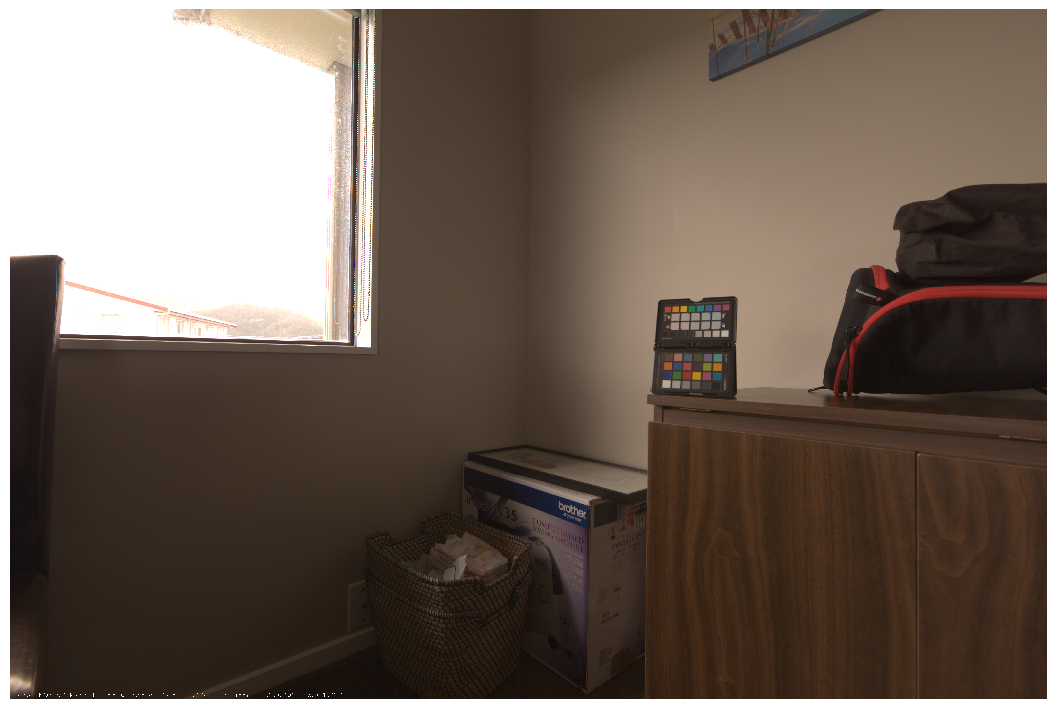

In [5]:
raw_file_path = RAW_FILES[-2]

graph.set_input("raw_file_path", raw_file_path)
graph.set_input("output_file_path", raw_file_path.replace(".CR2", ".exr"))

graph.process()

colour.plotting.plot_image(colour.cctf_encoding(colour.read_image(graph.get_output("output"))));

## Processing a Single Image (Camera Sensitivities)

In [6]:
print(colour_datasets.datasets())

DATABASE_SENSITIVITIES = colour.utilities.CanonicalMapping(
    {
        "canon-eos-5d-mark-ii" : colour_datasets.load("3372171")["camera"]["canon eos 5d mark ii"]
    }
)

print(list(DATABASE_SENSITIVITIES.keys()))

colour-science-datasets

Datasets : 23
Synced   : 4
URL      : https://zenodo.org/communities/colour-science-datasets

Datasets
--------

[ ] 3269926 : Agfa IT8.7/2 Set - Marszalec (n.d.)
[x] 8314702 : Camera Dataset - Solomatov and Akkaynak (2023)
[ ] 3245883 : Camera Spectral Sensitivity Database - Jiang et al. (2013)
[ ] 3367463 : Constant Hue Loci Data - Hung and Berns (1995)
[ ] 3362536 : Constant Perceived-Hue Data - Ebner and Fairchild (1998)
[ ] 3270903 : Corresponding-Colour Datasets - Luo and Rhodes (1999)
[ ] 3269920 : Forest Colors - Jaaskelainen et al. (1994)
[ ] 4394536 : LUTCHI Colour Appearance Data - Luo and Rhodes (1997)
[x] 3245875 : Labsphere SRS-99-020 - Labsphere (2019)
[ ] 3269924 : Lumber Spectra - Hiltunen (n.d.)
[ ] 4051012 : Measured Commercial LED Spectra - Brendel (2020)
[ ] 3269918 : Munsell Colors Glossy (All) (Spectrofotometer Measured) - Orava (n.d.)
[ ] 3269916 : Munsell Colors Glossy (Spectrofotometer Measured) - Haanpalo (n.d.)
[ ] 3269914 : Munsell 

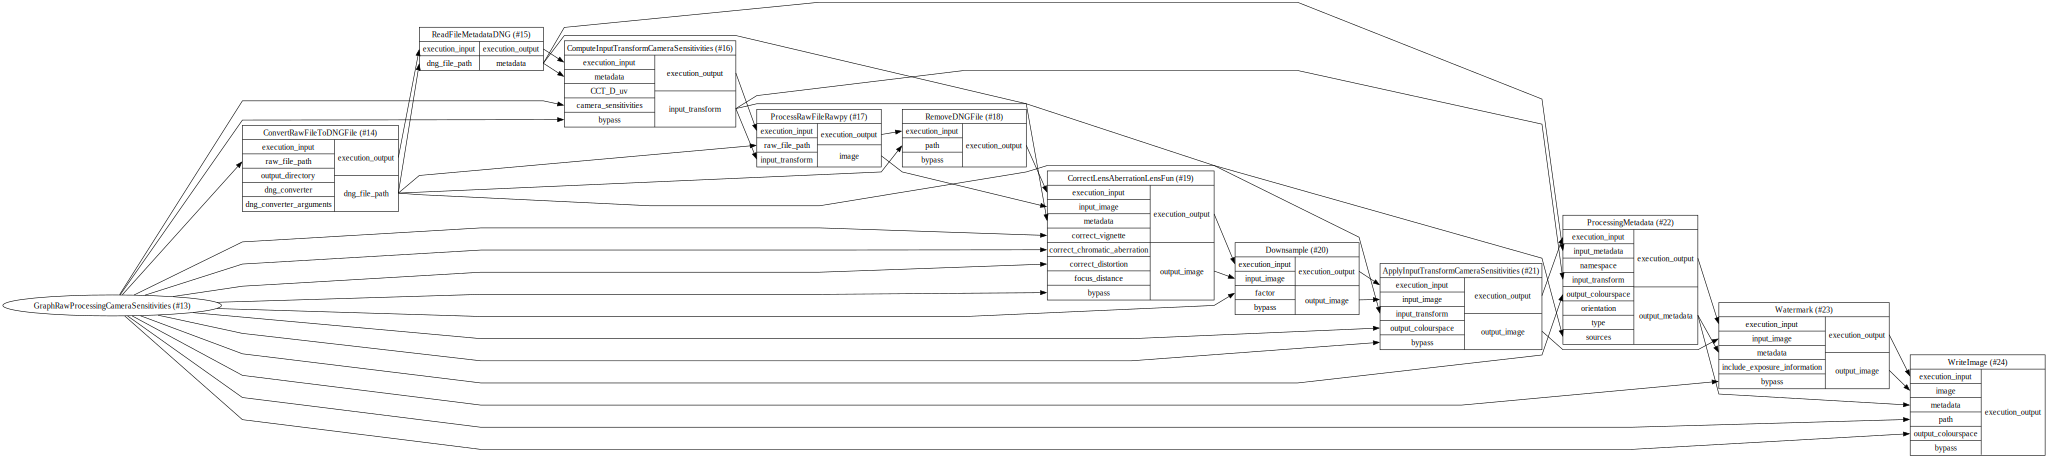

In [7]:
graph = GraphRawProcessingCameraSensitivities()
to_graphviz = graph.to_graphviz()
to_graphviz.layout(prog="dot")
to_graphviz

2024-07-28 20:57:40,275 - 25734 - INFO - GraphRawProcessingCameraSensitivities: Processing "NodeConvertRawFileToDNGFile#14(None)" node...
2024-07-28 20:57:40,275 - 25734 - INFO - Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
2024-07-28 20:57:40,882 - 25734 - INFO - GraphRawProcessingCameraSensitivities: Processing "NodeReadFileMetadataDNG#15(None)" node...
2024-07-28 20:57:40,883 - 25734 - INFO - Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.dng" image EXIF data.
2024-07-28 20:57:41,028 - 25734 - INFO - GraphRawProcessingCameraSensitivities: Processing "

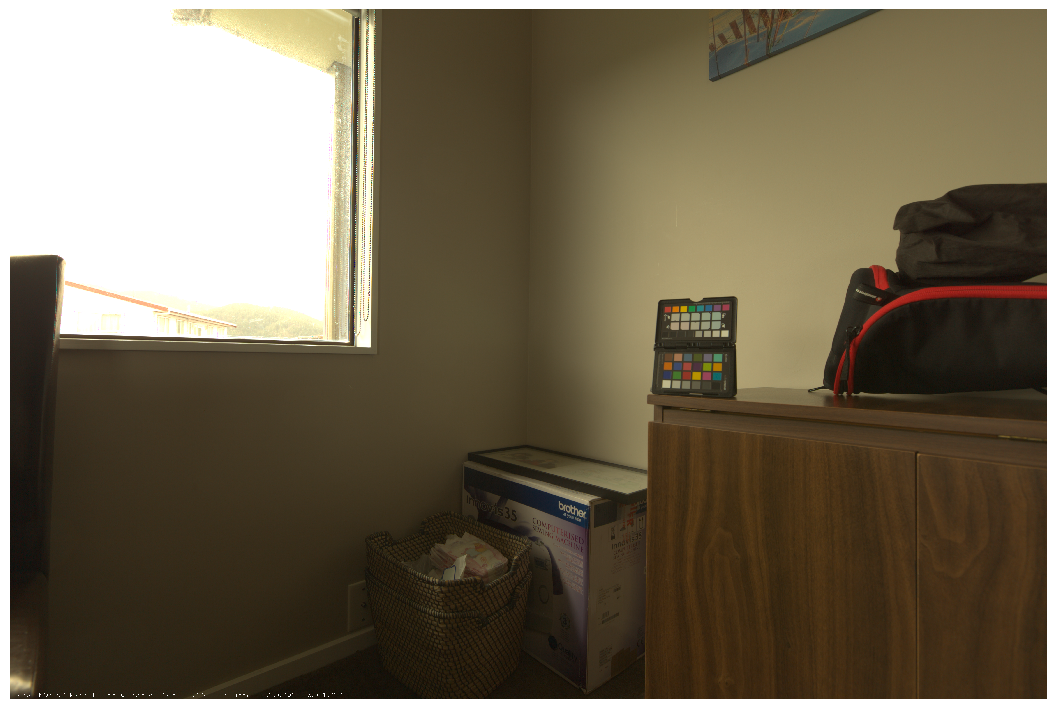

In [8]:
raw_file_path = RAW_FILES[-2]

graph.set_input("raw_file_path", raw_file_path)
graph.set_input("output_file_path", raw_file_path.replace(".CR2", ".exr"))
graph.set_input("camera_sensitivities", DATABASE_SENSITIVITIES)

graph.process()

colour.plotting.plot_image(colour.cctf_encoding(colour.read_image(graph.get_output("output"))));

## Processing and Merging Multiple Images to HDRI

The graph used to process and merge multiple images to HDRI is complex and uses multiple nested sub-graphs and parallel for loops leveraging multiprocessing:

- `GraphHDRI`
    - Loop Output: `GraphRawProcessingCameraSensitivities`
    - Execution Output: `GraphBatchMergeHDRI`
        - Loop Output: `GraphMergeHDRI`
        - Execution Output: `GraphPostMergeHDR`

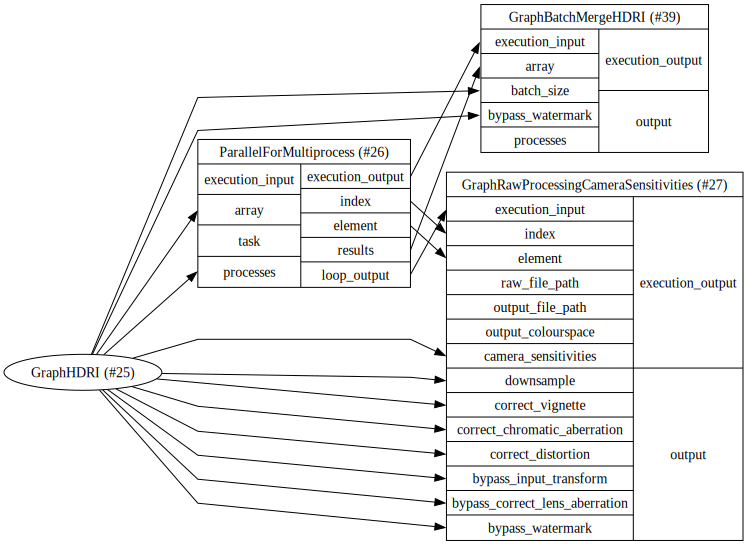

In [9]:
graph = GraphHDRI()
to_graphviz = graph.to_graphviz()
to_graphviz.layout(prog="dot")
to_graphviz

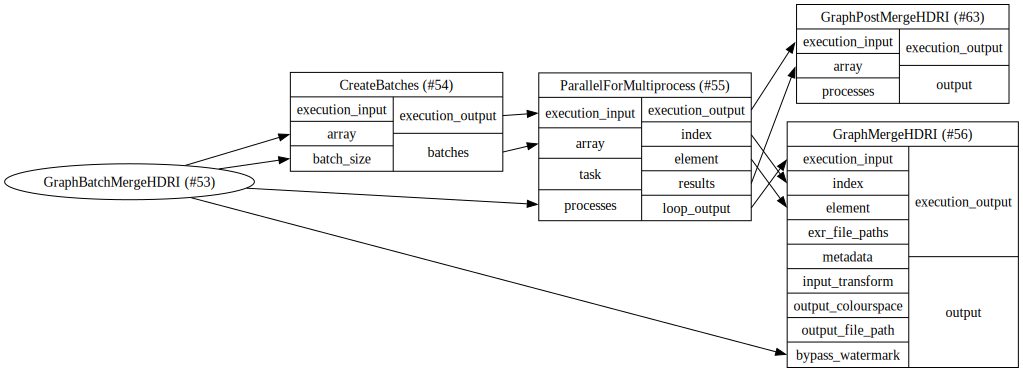

In [10]:
graph = GraphBatchMergeHDRI()
to_graphviz = graph.to_graphviz()
to_graphviz.layout(prog="dot")
to_graphviz

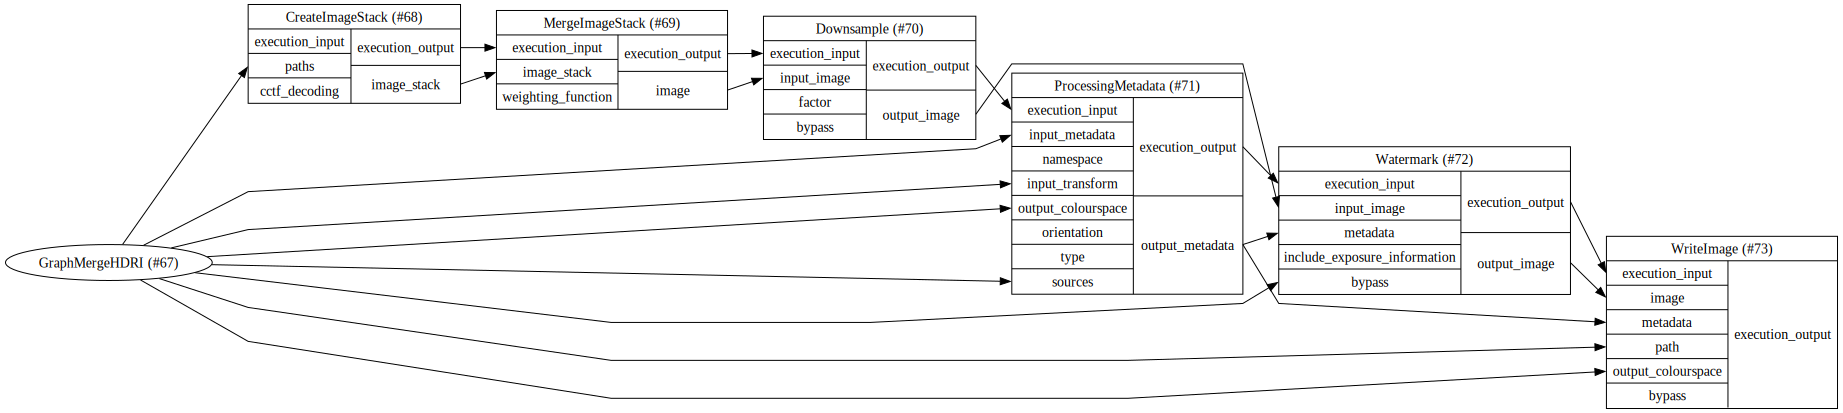

In [11]:
graph = GraphMergeHDRI()
to_graphviz = graph.to_graphviz()
to_graphviz.layout(prog="dot")
to_graphviz

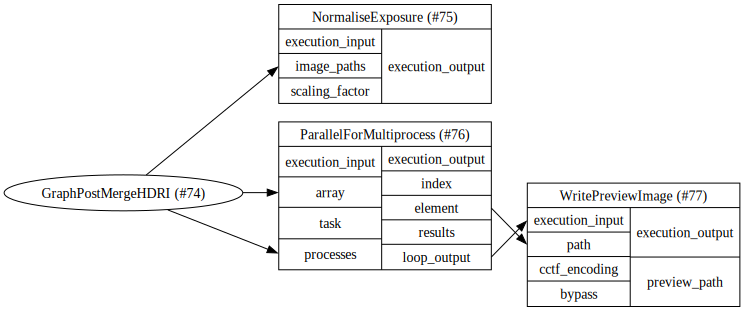

In [12]:
graph = GraphPostMergeHDRI()
to_graphviz = graph.to_graphviz()
to_graphviz.layout(prog="dot")
to_graphviz

2024-07-28 20:57:53,602 - 25734 - INFO - GraphHDRI: Processing "ParallelForMultiprocess#79(None)" node...
2024-07-28 20:57:53,603 - 25734 - INFO - ParallelForMultiprocess: Processing "GraphRawProcessingCameraSensitivities(11)" node...
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
2024-07-28 20:58:14,574 - 25734 - INFO - ParallelForMultiprocess: Processed "('/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.exr', CanonicalMapping({'EXIF': CanonicalMapping({'Make': 'Canon', 'Camera Model Name': 'Canon EOS 5D Mark II', 'Camera Serial Number': '330229410', 'Lens Model': 'EF16-35mm f/2.8L II USM', 'DNG Lens Info': '16 35 undef undef', 'F

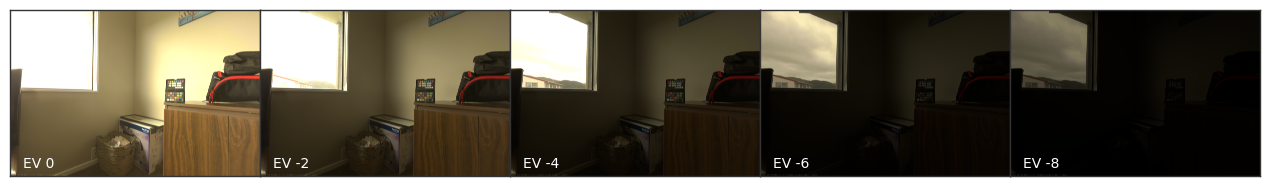

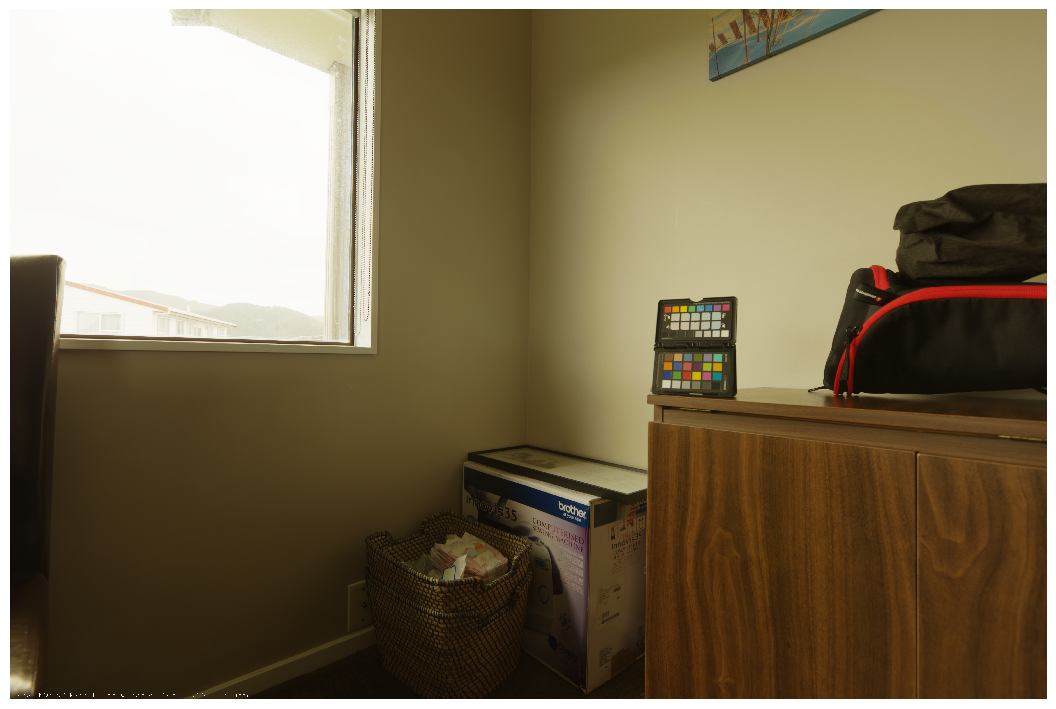

In [13]:
graph = GraphHDRI()
graph.set_input("array", RAW_FILES)
graph.set_input("camera_sensitivities", DATABASE_SENSITIVITIES)
graph.set_input("batch_size", 5)
graph.process()

plot_HDRI_strip(colour.read_image(graph.get_output("output")[0][0]))

colour.plotting.plot_image(colour.read_image(graph.get_output("output")[0][1]));